In [1]:
import numpy as np
import time,os
from io import StringIO
np.set_printoptions(linewidth=160)
from lib.ktn_io import *
from lib.gt_tools import *
from scipy.sparse import save_npz, load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Using tqdm package for pretty progress bars!


In [3]:

data_path = "KTN_data/LJ38/4k"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

Nmax=None

Aind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.A')):
    Aind = np.append(Aind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Aind = Aind[2:]

Bind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.B')):
    Bind = np.append(Bind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Bind = Bind[2:]

print(Bind.size)


395


# Load Data, define regions, calculate $\langle\tau^{1,2}\rangle$


# $\langle\tau\rangle 
= \sum_\xi \sum_{\xi_l\in\xi} \tau_{\xi_l} P_{\xi} 
= \langle\sum_p\tau_{\in p}\rangle
= \sum_p {\langle\tau_{\in p}\rangle}
= \sum_p{\rm x}_p = {\bf 1}\cdot{\bf x}$


---------






N,N_TS: 4000 2653
Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900 (4000,) (4000,)
[1 2 3 4 5]
6 7 8 9 10 11 12 13 14 15  
16 17 18 19 20 21 22 23 24 25  
26 27 28 29 30 31 32 33 34 35  
36 37 38 39 40 41 42 43 44 45  
46 47 48 49 50 51 52 53 54 55  
56 57 58 59 60 61 62 63 64 65  
66 67 68 69 70 71 72 73 74 75  
76 77 78 79 80 81 82 83 84 85  
86 87 88 89 90 91 92 93 94 95  
96 97 98 99 100 101 102 103 104 105  
106 107 108 109 110 111 112 113 114 115  
116 117 118 119 120 121 122 123 124 125  
126 127 128 129 130 131 132 133 T= 0.15 tau: 3142187.8579967963 tau^2: 2.2443223273612016 2.2443223273612016
T= 0.15 tau: 29649191.4912702 tau^2: 0.6666777633903211 0.6666777632837376
David:
  29649201.19, 0.6875005231E+0016
3142186.826, 0.2245162179E+0017


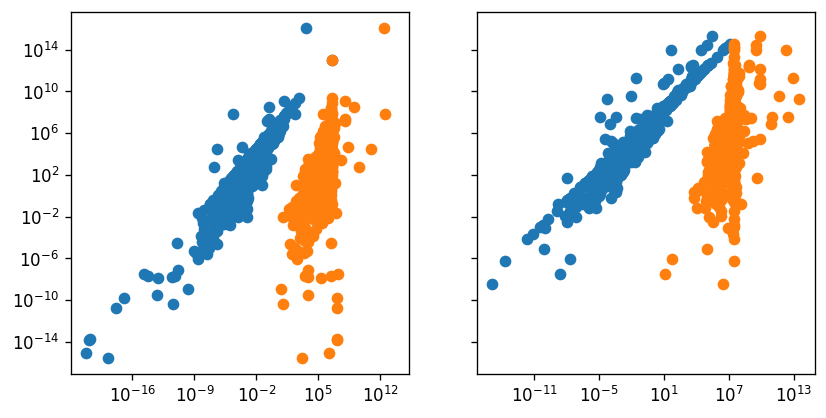

In [10]:
fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120,sharey=True)

beta = 1.0/0.15
B, K, D, N, u, s, Emin, sel = load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
D = np.ravel(K.sum(axis=0))

Q = diags(D)-K.copy()

keep = np.zeros(sel.size,bool)
keep[Bind] = True

B_states = keep[sel]

keep = np.zeros(sel.size,bool)
keep[Aind] = True
A_states = keep[sel]

print(np.arange(N)[A_states]+1)
c=1
for b in np.arange(N)[B_states]:
    print(b+1,end=" ")
    if c%10==0:
        print(" ")
    c+=1

BF = beta*u-s
    
    
rho = np.exp(-BF) 
    

rho_A = rho.copy()
rho_B = rho.copy()
rho_A[~A_states] = 0.0
rho_B[~B_states] = 0.0
rho_A = rho_A[~B_states]
rho_B = rho_B[~A_states]
rho_A /= rho_A.sum()
rho_B /= rho_B.sum()
rho = [rho_A,rho_B]
sel = [~B_states,~A_states]

for j in range(2):
    x = spsolve(Q[sel[j],:][:,sel[j]],rho[j])
    y = spsolve(Q[sel[j],:][:,sel[j]],x)
    
    z = spsolve(Q[sel[j],:][:,sel[j]].transpose(),np.ones(rho[j].size)) # GT tau from each state
    
    
    
    #z = 2.0/D[sel[j]] * x
    axs[j].loglog(x,z*x,'o')
    axs[j].loglog(z,z*x,'o')
    
    
    
    
    print("T=",1.0/beta,"tau:",x.sum(),"tau^2:", 2.0*y.sum()/1.0e16, 2.0*(z*x).sum()/1.0e16, )

print("David:\n  29649201.19, 0.6875005231E+0016\n3142186.826, 0.2245162179E+0017")

In [6]:

betar = np.linspace(0.01,1.0/0.15,40)#arange(1,9)
tau = np.zeros((betar.size,8))
for i in range(betar.size):
    
    B, K, D, N, u, s, Emin, sel = load_mat(path=data_path,beta=betar[i],Emax=None,Nmax=None,screen=(i==0))
    
    #beta, B, K, D, N, u, s, kt, kcon, Emin, sel = load_save_mat(path=data_path,beta=betar[i],Emax=None,Nmax=None,generate=generate)
    D = np.ravel(K.sum(axis=0))
    
    Q = diags(D)-K.copy()
    
    keep = np.zeros(sel.size,bool)
    keep[Bind] = True
    
    B_states = keep[sel]
    
    keep = np.zeros(sel.size,bool)
    keep[Aind] = True
    A_states = keep[sel]
    
    
    if i==0:
        print("N_A: %d, N_B: %d" % (A_states.sum(),B_states.sum()))
    
    BF = betar[i]*u-s
    
    
    rho = np.exp(-BF) 
    
    
    rho_A = rho.copy()
    rho_B = rho.copy()
    rho_A[~A_states] = 0.0
    rho_B[~B_states] = 0.0
    rho_A = rho_A[~B_states]
    rho_B = rho_B[~A_states]
    rho_A /= rho_A.sum()
    rho_B /= rho_B.sum()
    rho = [rho_A,rho_B]
    sel = [~B_states,~A_states]
    
    
    inter_region = ~(B_states + A_states)
    rB, rD, full_rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50)
    r_A_states = A_states[~inter_region]
    r_B_states = B_states[~inter_region]
    r_BF = BF[~inter_region]
    
    r_rho = np.exp(-r_BF) 
    r_rho_A = r_rho.copy()
    r_rho_B = r_rho.copy()
    r_rho_A = r_rho_A[~r_B_states]
    r_rho_B = r_rho_B[~r_A_states]
    r_rho_A /= r_rho_A.sum()
    r_rho_B /= r_rho_B.sum()
    r_rho = [r_rho_A,r_rho_B]
    r_sel = [~r_B_states,~r_A_states]
    
    
    
    for j in range(2):
        x = spsolve(Q[sel[j],:][:,sel[j]],rho[j])
        y = spsolve(Q[sel[j],:][:,sel[j]],x)
        print("T=",1.0/betar[i],"tau:",x.sum(),"tau^2:",2.0*y.sum())
        tau[i][2*j+0] = x.sum()
        tau[i][2*j+1] = np.sqrt(2.0*y.sum()-tau[i][2*j]**2)
        """
        nu,v,w = spla.eig(Q.todense()[sel[j],:][:,sel[j]],left=True,right=True)
        nu = nu.real
        v = v.real
        w = w.real
        
        for nui in range(nu.size):
            www = w[:,nui].sum() * (v[:,nui]*rho[j]).sum() / np.dot(w[:,nui],v[:,nui])
            
            tau[i][4+2*j+0] += www / nu[nui]
            
            tau[i][4+2*j+1] += 2.0 * www / nu[nui] / nu[nui]
        
        tau[i][4+2*j+1] = np.sqrt(tau[i][4+2*j+1]-tau[i][4+2*j+0]**2)
        
        """
        
        x = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],r_rho[j])
        y = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],x)
        
        tau[i][4+2*j+0] = x.sum()
        tau[i][4+2*j+1] = np.sqrt(2.0*y.sum()-tau[i][4+2*j]**2)
        
#    pbar.update(1)
#pbar.close()
        
    



Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900
N_A: 5, N_B: 128


T= 100.0 tau: 188214.37270594068 tau^2: 58694990407283.44
T= 100.0 tau: 7334.133010868336 tau^2: 311867485.50866705


T= 5.53453169347209 tau: 189233.98307383325 tau^2: 75690990699669.55
T= 5.53453169347209 tau: 7267.892531086367 tau^2: 273197861.2683348


T= 2.8460228654828503 tau: 190045.77787207506 tau^2: 97532581444234.0
T= 2.8460228654828503 tau: 7288.92844136567 tau^2: 246488450.45105088


T= 1.9155206286836932 tau: 191803.68176489198 tau^2: 126334005467212.94
T= 1.9155206286836932 tau: 7394.323954459413 tau^2: 229317905.91722876


T= 1.4435533621221466 tau: 195728.4245220447 tau^2: 165496991689394.4
T= 1.4435533621221466 tau: 7583.080371929866 tau^2: 220006082.54123235


T= 1.158186497723223 tau: 202776.28209077026 tau^2: 220143389181844.16
T= 1.158186497723223 tau: 7855.68140838179 tau^2: 217453721.37931767


T= 0.967022067939499 tau: 213278.05478163727 tau^2: 297336597501320.75
T= 0.967022067939499 tau: 8213.318548516163 tau^2: 221007045.82817027


T= 0.8300227014755959 tau: 226883.89730792347 tau^2: 406224850282025.25
T= 0.8300227014755959 tau: 8656.797706944664 tau^2: 230333776.53964636


T= 0.7270241720002485 tau: 242950.7142747898 tau^2: 558697674595483.7
T= 0.7270241720002485 tau: 9185.506578869798 tau^2: 245311542.68524486


T= 0.6467661691542287 tau: 260957.15705013735 tau^2: 770813545440724.9
T= 0.6467661691542287 tau: 9797.13642506104 tau^2: 265949955.31315577


T= 0.5824662717180266 tau: 280403.5393113057 tau^2: 1063903474136055.1
T= 0.5824662717180266 tau: 10488.984391965085 tau^2: 292392345.7001294


T= 0.5297953269335265 tau: 300285.46244427375 tau^2: 1463529634477953.8
T= 0.5297953269335265 tau: 11261.318474461783 tau^2: 325057029.70316267


T= 0.48586022175158833 tau: 318752.7996798218 tau^2: 1995600644128254.5
T= 0.48586022175158833 tau: 12122.03475170396 tau^2: 364941958.88245445


T= 0.44865403788634095 tau: 333321.49189567304 tau^2: 2680617801988312.5
T= 0.44865403788634095 tau: 13090.541642030861 tau^2: 414043552.6104932


T= 0.41674087266251114 tau: 341466.16602852405 tau^2: 3527504475523715.5
T= 0.41674087266251114 tau: 14199.581463399227 tau^2: 475850954.9650951


T= 0.3890662410215483 tau: 341245.27897577913 tau^2: 4528231801443012.0
T= 0.3890662410215483 tau: 15496.209438645023 tau^2: 556033451.2034761


T= 0.36483831737815337 tau: 331767.7818708529 tau^2: 5654960096529016.0
T= 0.36483831737815337 tau: 17044.176023275737 tau^2: 663615883.6649361


T= 0.34345094815945515 tau: 313433.86319061834 tau^2: 6862192569473519.0
T= 0.34345094815945515 tau: 18928.743256175043 tau^2: 813059292.3440084


T= 0.3244322435737459 tau: 287879.9243349283 tau^2: 8095335679211905.0
T= 0.3244322435737459 tau: 21263.761497812746 tau^2: 1027855243.3136408


T= 0.30740935365212824 tau: 257591.07353291503 tau^2: 9303396348935002.0
T= 0.30740935365212824 tau: 24200.738771475677 tau^2: 1346655580.158661


T= 0.292083780612627 tau: 225293.15767434743 tau^2: 1.0450130062330612e+16
T= 0.292083780612627 tau: 27940.13267544397 tau^2: 1833716584.7122283


T= 0.2782137252104437 tau: 193371.45527490595 tau^2: 1.1518557245027752e+16
T= 0.2782137252104437 tau: 32745.824005498616 tau^2: 2596761596.462091


T= 0.26560123493223764 tau: 163530.35958790567 tau^2: 1.2508186800353484e+16
T= 0.26560123493223764 tau: 38965.23285187059 tau^2: 3817835927.224059


T= 0.2540826963168867 tau: 136740.7175013215 tau^2: 1.3428299564112744e+16
T= 0.2540826963168867 tau: 47061.35877441145 tau^2: 5807952257.934918


T= 0.2435216984077427 tau: 113378.70713969594 tau^2: 1.4291276487475242e+16
T= 0.2435216984077427 tau: 57671.87321387959 tau^2: 9109120665.216412


T= 0.23380360497182365 tau: 93428.86431854844 tau^2: 1.5108130981222956e+16
T= 0.23380360497182365 tau: 71727.9934237012 tau^2: 14702505857.044754


T= 0.22483137646764922 tau: 76669.41215285822 tau^2: 1.5886469888736848e+16
T= 0.22483137646764922 tau: 90695.91376828961 tau^2: 24484290328.146797


T= 0.21652231845436376 tau: 62814.97513800857 tau^2: 1.6630186430432222e+16
T= 0.21652231845436376 tau: 117048.67234752385 tau^2: 42480500804.402504


T= 0.2088055253154391 tau: 51629.675772781535 tau^2: 1.7340090177366674e+16
T= 0.2088055253154391 tau: 155141.30670246127 tau^2: 78220336647.33408


T= 0.2016198518007927 tau: 43045.95720040666 tau^2: 1.8014891757111964e+16
T= 0.2016198518007927 tau: 212766.4011320792 tau^2: 156634778229.90393


T= 0.1949122894697386 tau: 37347.634270961054 tau^2: 1.865218977209156e+16
T= 0.1949122894697386 tau: 303862.12217475416 tau^2: 348130279460.0804


T= 0.1886366567780214 tau: 35520.16033022744 tau^2: 1.9249278343800036e+16
T= 0.1886366567780214 tau: 453224.5024297625 tau^2: 862014883676.412


T= 0.1827525343246747 tau: 39966.83706939811 tau^2: 1.98037108291856e+16
T= 0.1827525343246747 tau: 704783.5313455234 tau^2: 2340950842244.0674


T= 0.17722439334726892 tau: 55992.00461577594 tau^2: 2.0313630196608976e+16
T= 0.17722439334726892 tau: 1136269.0608348888 tau^2: 6797614084661.442


T= 0.17202087774755567 tau: 94872.53560779574 tau^2: 2.077791653239574e+16
T= 0.17202087774755567 tau: 1885335.238289883 tau^2: 20611685648204.91


T= 0.16711420899274407 tau: 180205.2203140295 tau^2: 2.119621922424528e+16
T= 0.16711420899274407 tau: 3196209.279822999 tau^2: 64154356858029.66


T= 0.16247969003874513 tau: 360996.8859497582 tau^2: 2.1568964435136276e+16
T= 0.16247969003874513 tau: 5503101.247673426 tau^2: 202767594272799.0


T= 0.15809528957111582 tau: 738611.8366838074 tau^2: 2.1897543592582336e+16
T= 0.15809528957111582 tau: 9579511.175564894 tau^2: 646627783317672.5


T= 0.15394129179111352 tau: 1522160.1630800162 tau^2: 2.2185422689603044e+16
T= 0.15394129179111352 tau: 16805795.136544295 tau^2: 2072987198748538.2


T= 0.15 tau: 3142187.8579967963 tau^2: 2.2443223273612016e+16
T= 0.15 tau: 29649191.4912702 tau^2: 6666777633903211.0


# Plot

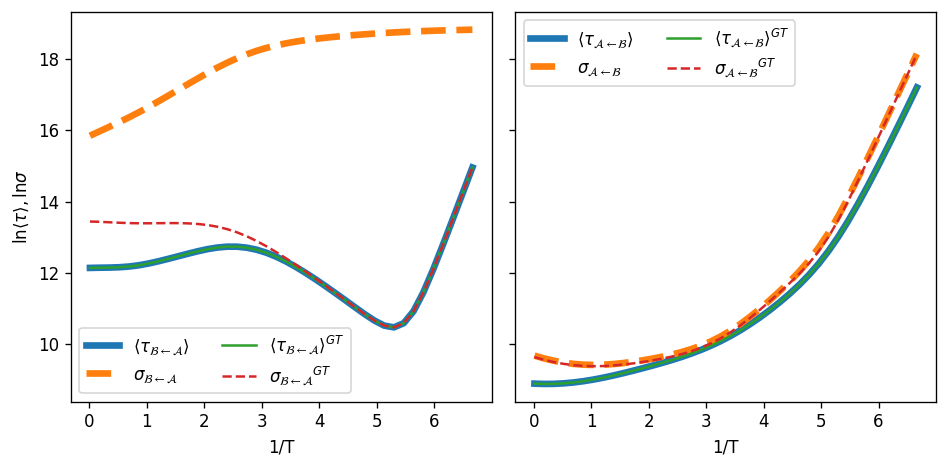

In [13]:
#"\sqrt{\langle\tau^2_{\mathcal{B\leftarrow A}}\rangle-\langle\tau_{\mathcal{B\leftarrow A}}\rangle^2}$",\
fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120,sharey=True)
labs = [r"$\langle\tau_{\mathcal{B\leftarrow A}}\rangle$",
        r"$\sigma_{\mathcal{B\leftarrow A}}$",\
        r"$\langle\tau_{\mathcal{A\leftarrow B}}\rangle$",\
        r"$\sigma_{\mathcal{A\leftarrow B}}$"]
for k in range(2):
    axs[k].plot((betar),np.log(tau[:,2*k]),'-',label=labs[2*k],lw=4)
    axs[k].plot((betar),np.log(tau[:,2*k+1]),'--',label=labs[2*k+1],lw=4)

for k in range(2):
    axs[k].plot((betar),np.log(tau[:,4+2*k]),'-',label=labs[2*k]+r"$^{GT}$")
    axs[k].plot((betar),np.log(tau[:,4+2*k+1]),'--',label=labs[2*k+1]+r"$^{GT}$")

axs[0].legend(ncol=2)
axs[1].legend(ncol=2)
axs[0].set_ylabel(r"$\ln\langle\tau\rangle,\ln\sigma$")
axs[0].set_xlabel("1/T")
axs[1].set_xlabel("1/T")
plt.tight_layout()
plt.savefig("finally_agreement.pdf")

7.0
6.144731553169849e-15


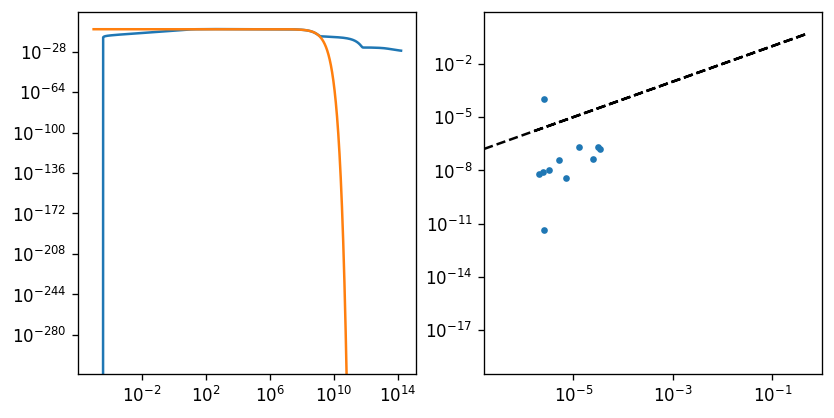

In [41]:
beta = 7.0

B, K, D, N, u, s, Emin, sel = load_mat(path=data_path,beta=beta,Emax=None,Nmax=None)

D = np.ravel(K.sum(axis=0))

BF = beta*u-s

keep = np.zeros(sel.size,bool)
keep[Aind] = True
B_states = keep[sel]

keep = np.zeros(sel.size,bool)
keep[Bind] = True
A_states = keep[sel]

inter_region = ~A_states + ~B_states

Q = (np.diag(D)-K.todense())[~B_states,:][:,~B_states]
print(beta)
rho = np.exp(-BF)
rho[~A_states] = 0.0
rho = rho[~B_states]
rho /= rho.sum()

nu,v,w = spla.eig(Q,left=True,right=True)
nu = nu.real
v = v.real
w = w.real
print(nu.min())

t = np.exp(np.linspace(np.log(.00001),np.log(1.0/nu.min()),1000))
tau = 0.0
p = np.zeros(t.size)
for i in range(nu.size):
    www = w[:,i].sum() * (v[:,i]*rho).sum() / np.dot(w[:,i],v[:,i])
    p += www * nu[i] * np.exp(-nu[i]*t)
    tau += www / nu[i]

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120)

axs[0].plot(t,p,'-')
axs[0].plot(t,np.exp(-t/tau)/tau,'-')


axs[1].plot(rho/rho.sum(),w[:,nu.argmin()]/w[:,nu.argmin()].sum(),'.')
axs[1].plot(rho/rho.sum(),rho/rho.sum(),'k--')

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
    

# Graph transformation to remove intermediate states

In [42]:
trmb = 50 # block size


# NB "full_rK" is in fact equal to D-K=(1-B).D in earlier notation - this is done 

rB, rD, full_rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=trmb,retK=True,Ndense=50)


r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]
r_BF = BF[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]
rDSS = D[~inter_region]





ValueError: k exceeds matrix dimensions

# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## We also perform same eigendecomposition following additional GT to group all target states

## This is analytically identical, but in practice is numerically beneficial

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=160)

kdata = [] # SS,NSS,QSD,nu

for i, r_s in enumerate([r_A_states,r_B_states]) :
        
    l, v = spla.eig(full_rK[r_s,:][:,r_s].todense())
    
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    
    
    
    
    
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
    
    
    
    
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool)   
    rm_reg[(~r_s).nonzero()[0]] = True
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    
    rrB, rrD, full_rrK, rrN, retry = gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,retK=True,Ndense=1)
    rr_s = r_s[~rm_reg]
    
    rl, rv = spla.eig(full_rrK[rr_s,:][:,rr_s].todense())
    
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    C = np.ravel(rrB[~rr_s,:][:,rr_s].sum(axis=0))
    
    
    irrK = spla.inv(full_rrK[rr_s,:][:,rr_s].todense())
    tau = irrK.dot(rho).sum(axis=0)
    T_AB = irrK.sum(axis=0)
    k_F = (rho/T_AB).sum()
    
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kSS = C.dot(np.diag(rDSS[r_s])).dot(rho)
    
    kNSS = C.dot(np.diag(rrD[rr_s])).dot(rho)
    
    kQSD = C.dot(np.diag(rrD[rr_s])).dot(qsd)
    
    oneKqsd = 0.0#(rrK[rr_s,:][:,rr_s].dot(qsd)).sum()
    
    kdata.append([kSS,kNSS,kQSD,rnu[0],oneKqsd,k_F,1.0/tau,qsd,rho])
    
    

       
    
    ax[i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],rnu[1]/rnu[0]))
    ax[i].set_ylabel("Eigenvalues")
    ax[i].set_xlabel("Index")
    ax[i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[i].set_yscale("log")
    ax[i].legend()
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}=k^{QSD}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^{SS}, k^{NSS}, k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"

## Results clearly show QSD for icosahedral basin is strongly non-Boltzmann ($k^{QSD}\neq k^{NSS}$)


In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    
    #     0: kSS, 1: kNSS, 2: kQSD, 3: nu, 4: 1.K.qsd, 5: k_F, 6: k* =1.0/tau
    
    print("\n\t nu_0 = %4.4g\n\n\t 1.K.qsd = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kQSD = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][2],(kdata[i][2]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kF = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][5],(kdata[i][5]/kdata[i][3])*100.0-100.0))
    
    print("\n\t k*= %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][6],(kdata[i][6]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][0],(kdata[i][0]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kNSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][1],(kdata[i][1]/kdata[i][3])*100.0-100.0))
    
    print("\n---QSD.max()=%4.10g, rho.max()=%4.10g ------\n\n" % (kdata[i][-2].max(),kdata[i][-1].max()))
    
        
    
    ax[0,i].set_title(r"QSD and Boltzmann for %s basin w/GT" % (names[i]))
    ax[0,i].set_ylabel("Occupation Probability")
    ax[0,i].set_xlabel("Basin State Index")
    ax[0,i].plot(kdata[i][-2],'s',label=r"QSD")
    ax[0,i].plot(kdata[i][-1],'o',label=r"Boltzmann")
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    ax[0,i].set_title(r"QSD vs Boltzmann for %s basin w/GT" % (names[i]))
    ax[1,i].set_xlabel("Boltzmann Occupation Probability")
    ax[1,i].set_ylabel("QSD Occupation Probability")
    ax[1,i].plot(kdata[i][-1],kdata[i][-2],'o',label=r"Boltzmann vs QSD")
    
    pc = np.linspace(min(kdata[i][-2].min(),kdata[i][-1].min()),1.0,10,endpoint=True)
    ax[1,i].plot(pc,pc,'k--',label="Boltz==QSD")
    
    ax[1,i].set_yscale("log")
    ax[1,i].set_xscale("log")
    ax[1,i].set_xlim(xmax=5.0)
    ax[1,i].set_ylim(ymax=5.0)
    
    ax[1,i].legend()
    
plt.tight_layout()